In [1]:
from collections import defaultdict
from typing import Optional
import numpy as np
from numba import njit, typed, prange
from tqdm import tqdm
from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd

from PartSegCore_compiled_backend.napari_mapping import map_array_parallel, map_array_sequential, zero_preserving_modulo_sequential, zero_preserving_modulo_parallel
from data_util import labeled_particles

sns.set_theme(style="darkgrid")

In [2]:
# code adapted  from napari.utils.colormaps.colormap

def get_dtype_py(num_colors: int):
    if num_colors < 255:
        return np.uint8
    if num_colors < 65536:
        return np.uint16
    return np.float32


get_dtype_nu = njit(get_dtype_py)

@njit(parallel=True)
def zero_preserving_modulo_numba(
    values: np.ndarray, n: int, to_zero: int=0, out: Optional[np.ndarray]=None, dtype: np.dtype = np.uint8
) -> np.ndarray:
    
    out = np.empty_like(values, dtype=dtype)
    for i in prange(values.size):
        if values.flat[i] == to_zero:
            out.flat[i] = 0
        else:
            out.flat[i] = (values.flat[i] - 1) % n + 1

    return out

@njit()
def zero_preserving_modulo_numba_seq(
    values: np.ndarray, n: int, to_zero: int=0, out: Optional[np.ndarray]=None, dtype: np.dtype = np.uint8
) -> np.ndarray:
    
    out = np.empty_like(values, dtype=dtype)
    for i in range(values.size):
        if values.flat[i] == to_zero:
            out.flat[i] = 0
        else:
            out.flat[i] = (values.flat[i] - 1) % n + 1

    return out

def zero_preserving_modulo_numpy(
    values: np.ndarray, n: int, dtype: np.dtype, to_zero: int = 0
) -> np.ndarray:
    res = ((values - 1) % n + 1).astype(get_dtype_py(n+1))
    res[values == to_zero] = 0
    return res


@njit(parallel=True)
def map_array_numba(
    data: np.ndarray, dkt: typed.Dict
) -> np.ndarray:
    if direct_colormap.use_selection:
        return (data == direct_colormap.selection).astype(np.uint8)

    dkt = direct_colormap._get_typed_dict_mapping(data.dtype)
    target_dtype = minimum_dtype_for_labels(
        direct_colormap._num_unique_colors + 2
    )
    result_array = np.full_like(
        data, MAPPING_OF_UNKNOWN_VALUE, dtype=target_dtype
    )
    for i in prange(data.size):
        val = data.flat[i]
        if val in dkt:
            result_array.flat[i] = dkt[result_array.flat[i]]

    return result_array

In [3]:
data_small_32 = np.arange(32*32, dtype=np.int32).reshape(32,32)
data_small_64 = np.arange(32*32, dtype=np.int64).reshape(32,32)
data_particles_2d_1024 = labeled_particles((1024, 1024), dtype=np.uint32)
data_particles_2d_2048 = labeled_particles((2048, 2048), n=500, dtype=np.uint32)
data_particles_3d_50_1024 = labeled_particles((50, 1024, 1024), dtype=np.uint32)
data_particles_3d_100_2048 = labeled_particles((100, 2048, 2048), dtype=np.uint32)
data_particles_3d_100_2048_54 = labeled_particles((100, 2048, 2048), dtype=np.uint64)

data_list = [
    (data_small_32, "data_small_32"), 
    (data_small_64, "data_small_64"),
    (data_particles_2d_1024, "data_particles_2d_1024"),
    (data_particles_2d_2048, "data_particles_2d_2048"), 
    (data_particles_3d_50_1024, "data_particles_3d_50_1024"),
    (data_particles_3d_100_2048, "data_particles_3d_100_2048"),
    (data_particles_3d_100_2048_54,"data_particles_3d_100_2048_54"),
]

In [4]:
random_data = []
random_data3d = []
for msize in [2 ** x for x in range(6, 14)]:
    values = np.random.randint(100000, size=(msize, msize), dtype=np.int32)
    random_data.append((values, f"random_({msize},{msize})_{msize*msize}"))
    values = np.random.randint(100000, size=(30, msize, msize), dtype=np.int32)
    random_data3d.append((values, f"random_(30,{msize},{msize})_{msize*msize*30}"))


In [5]:
for _ in range(10):
    zero_preserving_modulo_numba(data_small_32, n=49, to_zero=0, dtype=np.uint8)
    zero_preserving_modulo_numba_seq(data_small_32, n=49, to_zero=0, dtype=np.uint8)
    zero_preserving_modulo_numba(data_small_64, n=49, to_zero=0, dtype=np.uint8)

In [6]:
def measure_data(data_li):
    res = defaultdict(list)
    for data, name in tqdm(data_li):
        r = %timeit -o -q zero_preserving_modulo_numba(data, n=49, to_zero=0, dtype=np.uint8)
        res["numba"].append(r)
        r = %timeit -o -q zero_preserving_modulo_numba_seq(data, n=49, to_zero=0, dtype=np.uint8)
        res["numba seq"].append(r)
        r = %timeit -o -q zero_preserving_modulo_numpy(data, n=49, to_zero=0, dtype=np.uint8)
        res["numpy"].append(r)
        r = %timeit -o -q zero_preserving_modulo_sequential(data, modulo_factor=49, to_zero=0)
        res["cython seq"].append(r)
        r = %timeit -o -q zero_preserving_modulo_parallel(data, modulo_factor=49, to_zero=0)
        res["cython par"].append(r)
    return res
    

In [7]:
print("Profile modulo 49")
predef_res = measure_data(data_list)

Profile modulo 49


100%|███████████████████████████████████████████| 7/7 [04:23<00:00, 37.69s/it]


In [8]:
print("Profile random data modulo 49")
random_res = measure_data(random_data)

Profile random data modulo 49


100%|███████████████████████████████████████████| 8/8 [04:25<00:00, 33.24s/it]


In [9]:
print("Profile random data modulo 49")
random_res3d = measure_data(random_data3d)

Profile random data modulo 49


100%|███████████████████████████████████████████| 8/8 [06:51<00:00, 51.45s/it]


In [10]:
def make_dataframe(dkt, data_li):
    df_data = []
    for name, values in dkt.items():
        for tr, (data, data_name) in zip(values, data_li):
            for run in tr.timings:
                df_data.append([name, data_name, run])
    return pd.DataFrame(df_data, columns=["name", "data name", "run time"])
            

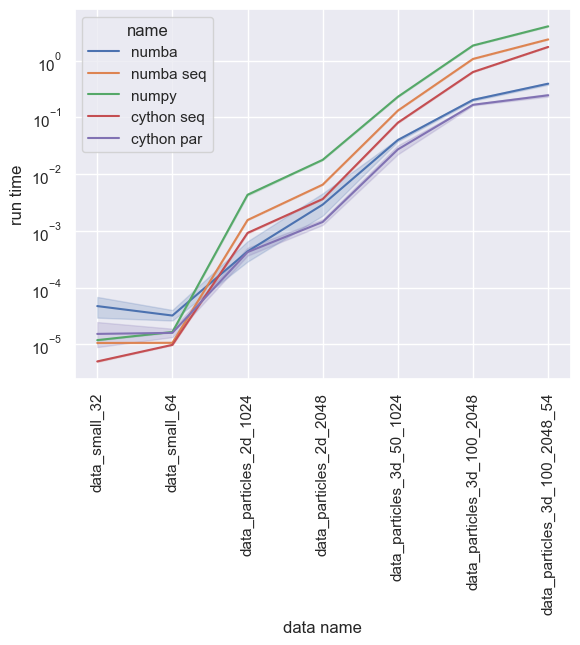

In [11]:
sns.lineplot(make_dataframe(predef_res, data_list), x="data name", y="run time", hue="name")
plt.xticks(*plt.xticks(), rotation="vertical")
plt.yscale('log')

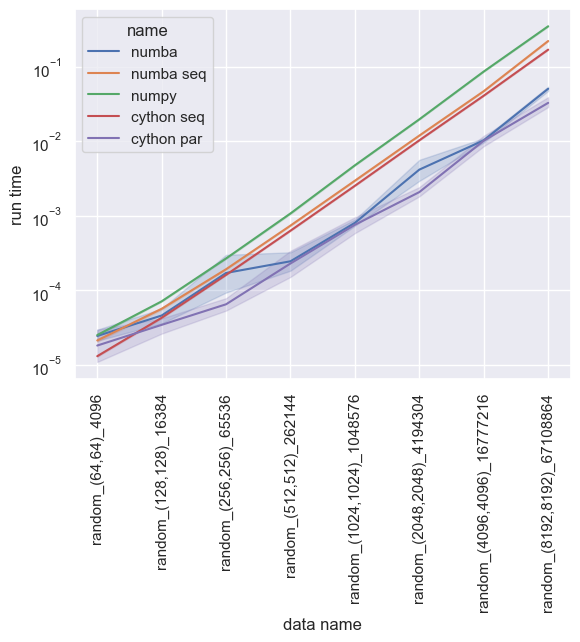

In [12]:
sns.lineplot(make_dataframe(random_res, random_data), x="data name", y="run time", hue="name")
plt.xticks(*plt.xticks(), rotation="vertical")
plt.yscale('log')

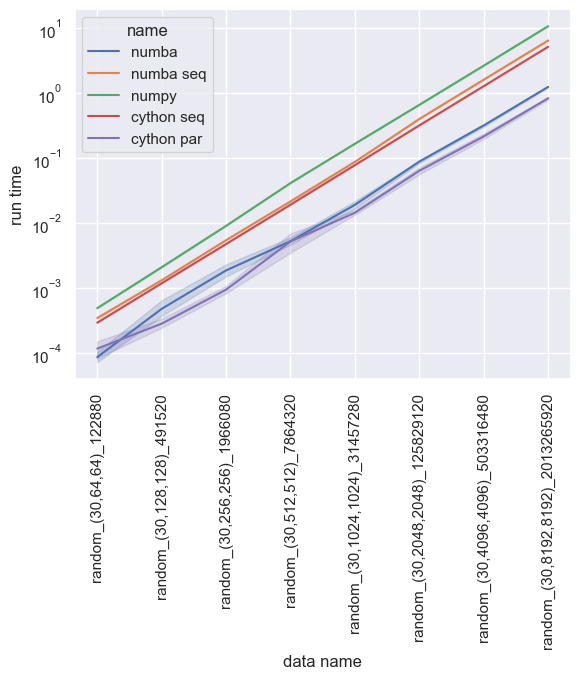

In [13]:
sns.lineplot(make_dataframe(random_res3d, random_data3d), x="data name", y="run time", hue="name")
plt.xticks(*plt.xticks(), rotation="vertical")
plt.yscale('log')


In [14]:
d = np.full((1,), 240)
%timeit zero_preserving_modulo_numba_seq(d, n=49, to_zero=0, dtype=np.uint8)
%timeit zero_preserving_modulo_numpy(d, n=49, to_zero=0, dtype=np.uint8)

8.11 µs ± 469 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
4.89 µs ± 173 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
